Simulated Annealing
=======

# Theory
**Simulated Annealing (SA)** is a metaheuristic optimization technique to approximate the global optimum of a function.

## Definition
**Simulated Annealing (SA)** technique is inspired from the annealing process in metals, hence the name; to achieve the optimization task. To get some context, lets recall the annealing process in metals
 
>Annealing process in metals starts by heating off the metal at very high temperatures and then cool it down with some predefined cooling schedule. During this process, the movement of particles in the metal progressively shift from fast and random motion "at high energy state" to slow and stationary motion "at low energy state" to eventually converge to the lowest energy state.

By analogy, simulated annealing want to model such explorative behaver that allowed the metal to visit different particles configurations at high energy state and eventually converged to the optimal particles configuration at the lowest energy state. To do that in context of optimization problems; some key concepts are imported from the physical process:
- Temperature
- Cooling schedule
- Energy state

These parameters will control how the algorithm explore the search space and its tolerance to accept worse less optimal solutions during search for the sake of exploration, and the convergence to global optimal eventually. This behaver is illustrated in the following gif where simulated annealing searching for optimal "maximum" point in a function. 
<div style="text-align:center"><img src="https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif" width="600"/></div>


### Algorithm
To elaborate more on how these imported components achieve the explorative behaver, lets illustrate the simulated annealing algorithm with this pusoducode.

<div style="text-align:center"><img src="./Resources/Simulated Annealing-Algorithm.png" width="800"/></div>

From the algorithm we can see the process of selecting a neighbor solution "$x_{\text{neighbor}}$" from the current solution neighborhood is a carried in a random manner by sampling. You can see this process in the following figure 
<div style="text-align:center"><img src="./Resources/Simulated Annealing-Neighbour.png" width="800"/></div>

This random selection of neighbor solution give the simulated annealing none zero probability to sample a worse solution, and then see if it will acceptance it according to accept probability. The part in the algorithm where the algorithm accept worse solutions with some accept probability is responsible for mimicking the explorative behaver. This accept probability is linked to the energy at the current state "i.e. high energy means that you have high probability to accept new solutions, even if they are worse"
$$
\begin{equation}
\text{Accept Probability} := E_i = e^{-\Delta \mathtt{cost} \,/\,\mathtt{T_i}}
\end{equation}$$

The energy of the current state is defined by temperature parameter $(\mathtt{T_i})$. The following plot shows how temperature $(\mathtt{T})$ plays a role in the energy hence the acceptance probability
<div style="text-align:center"><img src="./Resources/Simulated Annealing-Temperature.png" width="600"/></div>

One can see that at temperature $\mathtt{T} = 100$ the Accept Probability of a worse neighbored solutions "i.e. $\Delta \text{Cost} > 0$"  is much higher in comparison to $\mathtt{T} = 10$. 

From this relation we can achieve an explorative behaver "i.e. accept worse solutions" by starting the search with high temperature and then shift to more conservative behaver "i.e. reject worse solutions" by gradually decrease the temperature. The decay in temperature is controlled by predefined profile called the cooling schedule.
> It is worth noting that the algorithm always favour/accept better solution candidate, this will make the algorithm always goes back to area around global optima.


### Neighborhood Definition
The definition of neighborhood is vary vital to the performance of simulated annealing algorithm. However, defining the neighborhood is very tricky task and problem dependent. Bad definition of neighborhood can change the algorithm mechanics or alter it performance greatly. In simulated annealing the neighborhood of a current solution is defined as the bounding box around it. However, how large this bounding box should be is the tricky part of the neighborhood definition.

## Examples
Simulated annealing can be used to approximate the global optimal solution "either minima or maxima" to range of problems such as, not limited; the following:
- Mathematical function.
- N-Queens problem.
- Traveling sales man problem.

# Implementation
The approach to handle the implantation of the algorithm is to precompute the cooling schedule vector `T`, where the explorative/conservative behaver of the algorithm will be controlled by it. To do that, the user has to provide a mathematical function and a window "i.e function domain interval" to indicate the cooling schedule profile. To illustrate the idea, lets consider the case where the user provide the following 
- $T(t) = - t + 10 \quad$ where $\; t \in [0, 10]$ 
 
Based on this input we have a linear mathematical function defined a in given window $[0, 10]$, hence the cooling schedule vector `T` would read
$$ \mathtt{T} = 
\begin{bmatrix}
    10      \\
            \\
    \vdots  \\
            \\
    0       \\      
\end{bmatrix}
$$

> Noting that the resolution of the vector "i.e. spacing between elements" is controlled by sampling attempts that user specify.

## Imports

In [11]:
import math
import matplotlib
import numpy as np
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
matplotlib.rcParams['animation.embed_limit'] = 2**128

## Parameters

In [12]:
# cooling schedule
cooling_func = lambda t : 1000*np.exp(-0.7*t)                  # temperature decay function
cooling_window = [0,20]                                        # cooling function domain

## Algorithm
```mermaid
    flowchart TB

        window(cooling window) --> schedule(cooling schedule)
        func(cooling function) --> schedule(cooling schedule)

        x_0(Start with starting <br>solution x_0) --> Loop
        schedule --> Loop
        
        subgraph Loop
            direction LR

            sample(Sample a neighbor <br>of current solution) --> condition{Is neighbor cost better <br>than current cost?}
            condition --> |True| move(Move to neighbor)
            condition --> |False| probability{Move to neighbor with energy <br>driven probability}
            probability --> |Happened| move
            probability --> |Did not happen| stay(Stay where you are)

            move --> update(Update temperature)
            stay --> update

        end

        Loop --> return(Return current solution)
```

In [13]:
def SA(cost_func: Callable, get_neighborhood: Callable, x_0: float, cooling_schedule: tuple[Callable, list], maxiter: int = int(5e2)) -> tuple[float, list, int]:
    '''
    Simulated annealing algorithm to approximate the global optimum of a given cost function

    Args:
        cost_func: Cost function, define a metic that solutions will be optimized for, the function should return float
        get_neighborhood : Function that provide the neighborhood around current x value, should return np array
        x_0: Search starting value
        cooling_schedule: Cooling behavior, include cooling profile and window
        maxiter: Maximum number of iterations "i.e. sampling attempts in the given cooling schedule". Defaults to int(1e3).

    Returns:
        The optimal x value of the cost function, the number of accepted samples during search, and the search
        history record.
    '''

    
    # unpack arguments
    cooling_func, cooling_window = cooling_schedule

    # algorithm data
    T = cooling_func( np.linspace(*cooling_window, num=maxiter) )
    cost = [cost_func(x_0)]
    accepted_samples = 0
    x = [x_0]


    for i in range(maxiter-1):
        
        # randomly uniform sample a neighbor
        neighbors = get_neighborhood(x[-1])
        choice_index = np.random.choice(len(neighbors))
        sampled_neighbor = neighbors[choice_index]

        delta_cost = cost_func(sampled_neighbor) - cost_func(x[-1])

        # accept if neighbor is better, or accept with energy-driven probability if worse
        if delta_cost <= 0 or np.exp(-delta_cost/T[i]) > np.random.uniform(0,1):
            x.append(sampled_neighbor)
            cost.append(cost_func(sampled_neighbor))
            accepted_samples+=1

        # reject bad neighbor "stay where you are"
        else:
            x.append(x[-1])
            cost.append(cost_func(x[-1]))


    x_optimal, history = x[-1], pd.DataFrame({"cost": cost, "x": x, "temperature": T})

    return x_optimal, accepted_samples, history

## Results Visualization & Behaver Analysis
In this section we will illustrate the results and behavior of simulated annealing by solving the following problem
- Find global optima in a mathematical function
- Solve the N-Queens problem

We will illustrate the results of the algorithm in two means:
- gif Plot: Search process of algorithm to illustrate the transition from explorative to conservative search behaver
- Samples Plot: Search samples taken and show the suggest global optima
- Parameters Tracking Plot: SA parameters tracking, illustrate temperature cooling schedule, tacking of x value and cost to shows how algorithm explore search space


### Optima of Mathematical Function

In [14]:
# cost function and neighborhood definition
def cost_func(x: float) -> float:
    '''
    The cost is calculated use a mathematical expression "i.e. the mathematical function to be optimized"
    '''
    return 30*np.sin(x) + x**2

def get_neighborhood(x: float) -> np.array:
    '''
    The neighborhood around x is defined as the list of numbers that is close to x within a given range "i.e.
    an interval around x => [x-5, x+5]". Note that x is excluded from this list.
    '''
    interval_around_x = np.linspace(x-5, x+5) 
    return interval_around_x[ interval_around_x != x ]

# starting value search
x_0 = 2.5

In [15]:
x_optimal, accepted_samples, history = SA(cost_func=cost_func,
                                          get_neighborhood=get_neighborhood,
                                          x_0=x_0,
                                          cooling_schedule=(cooling_func, cooling_window), 
                                          )

In [16]:
%%capture
fig, ax = plt.subplots(figsize=(6,6))

# fine domain and range limits
xx = np.linspace(history["x"].min()-4, history["x"].max()+4, num=100)
y_lim = [np.min(cost_func(xx))-0.2*np.ptp(cost_func(xx)), np.max(cost_func(xx))+0.2*np.ptp(cost_func(xx))]

# simulated annealing sampling animation 
## statics components
main_function,      = ax.plot(xx, cost_func(xx), "k")
sample_x_ticks,     = ax.plot([history["x"][0]], [y_lim[0]], "r|", clip_on=False, zorder=100)
sample_line,        = ax.plot([], [], "r--")
sample_point,       = ax.plot([], [], "ro")
temperature_count,  = ax.plot([], [], "k>", label="Temperature = "+"{:.2f}".format(history["temperature"][0]))

## decorations
ax.set(xlabel="x", ylabel="f(x)", ylim=y_lim, title="Simulated Annealing Sampling")
legend = ax.legend()
ax.grid(True)

def animate(frame: int) -> tuple:

    ## animated components
    sample_line.set_data([history["x"][frame], history["x"][frame]], [y_lim[0], cost_func(history["x"][frame])])
    sample_point.set_data([history["x"][frame]], [cost_func(history["x"][frame])])
    sample_x_ticks.set_data([history["x"][:frame]], [y_lim[0]])
    legend.get_texts()[0].set_text("Temperature = "+"{:.2f}".format(history["temperature"][frame]))

    return sample_line, sample_point, sample_x_ticks

ani = FuncAnimation(fig, animate, frames=len(history["x"]), blit=True, interval=30)

ani.save('./Resources/Simulated Annealing-Result.gif', writer=PillowWriter(fps=30))

<div style="text-align:center"><img src="./Resources/Simulated Annealing-Result.gif" width="500"/></div>  
<em>If the gif is not updated, please reopen the notebook.</em>

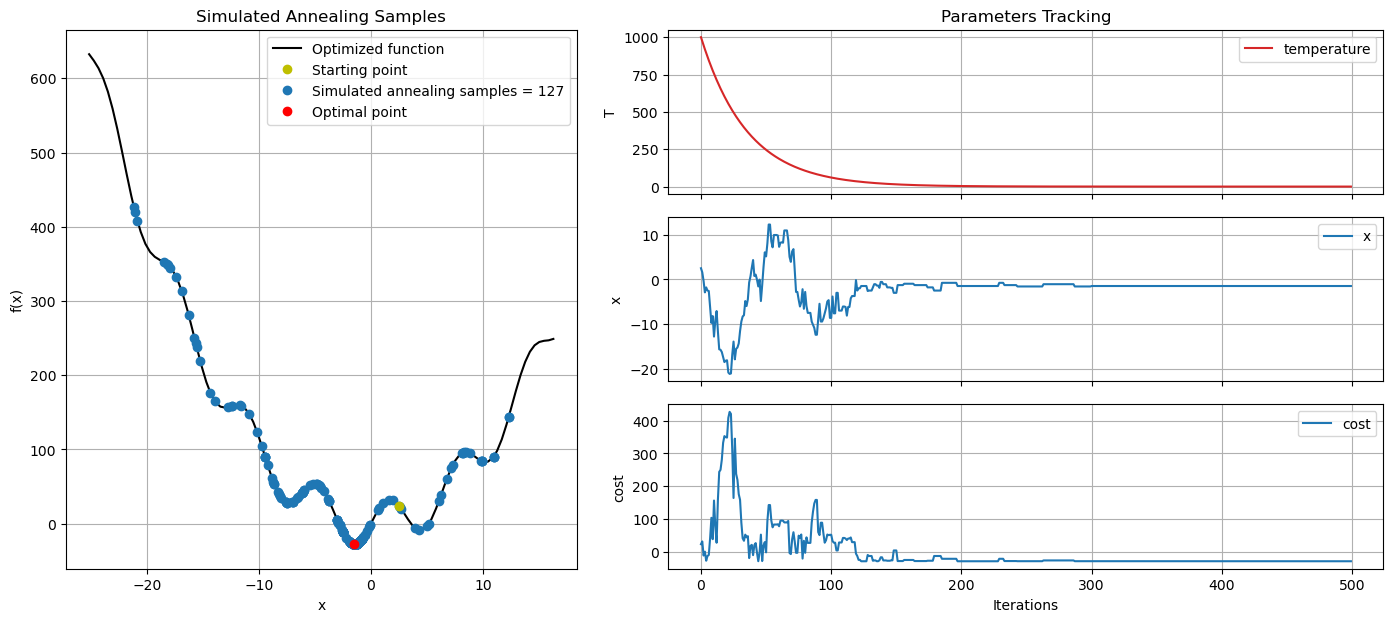

,Property,Value
0,optimal x,-1.479592
1,cost at optimal x,-27.686121
2,total search samples,500 samples
3,accepted samples,127 samples
4,rejected samples,373 samples


In [17]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                              ['upper left',       'right'],
                              ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})


# simulated annealing sampling plot
ax['upper left'].plot(xx, cost_func(xx), "k", label="Optimized function")
ax['upper left'].plot(history["x"][0], cost_func(history["x"][0]), "yo", label="Starting point", zorder=4)
ax['upper left'].plot(history["x"], cost_func(history["x"]), "o", label=f"Simulated annealing samples = {accepted_samples}")
ax['upper left'].plot(x_optimal, cost_func(x_optimal), "ro", label="Optimal point")
ax['upper left'].set(xlabel="x", ylabel="f(x)", title="Simulated Annealing Samples")
ax['upper left'].grid(True)
ax['upper left'].legend()

# temperature value tracking
ax['upper right'].plot(history["temperature"], "tab:red", label="temperature")
ax['upper right'].set(ylabel="T", title="Parameters Tracking")
ax['upper right'].xaxis.set_ticklabels([])
ax['upper right'].grid(True)
ax['upper right'].legend()

# x value tracking
ax['right'].plot(history["x"], label="x")
ax['right'].xaxis.set_ticklabels([])
ax['right'].set(ylabel="x")
ax['right'].grid(True)
ax['right'].legend()

# cost value tracking
ax['lower right'].plot(history["cost"], label="cost")
ax['lower right'].set(xlabel="Iterations", ylabel="cost")
ax['lower right'].grid(True)
ax['lower right'].legend()

# summary
summary = [
    ("optimal x", x_optimal),
    ("cost at optimal x", cost_func(x_optimal)),
    ("total search samples", f'{len(history["x"])} samples'),
    ("accepted samples", f'{accepted_samples} samples'),
    ("rejected samples", f'{len(history["x"]) - accepted_samples} samples')
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()
df

### N-Queens Problem
The following link will provide information on the problem
https://en.wikipedia.org/wiki/Eight_queens_puzzle

In [18]:
def cost_function(queens: np.array) -> float:
    '''
    The cost is calculated by counting the total number of attacks on the board. The attacks considered in this cost function are vertical, 
    horizontal and diagonal attacks. It should be noted that comitative attacks are counted once "For example, a vertical attack from Queen_i 
    on Queen_j is that same as the vertical attack from Queen_j on Queen_i, hence they are counted as 1 attack together"
    '''
    # collect queens positions in vertical and right/left diagonal lines "position described by line index"
    vertical_positions = queens
    right_diagonal_positions = -1*( 1*queens - np.arange(len(queens))*-1 )
    left_diagonal_positions  = -1*( -1*queens - np.arange(len(queens))*-1 )
    
    # check for attacks, by checking if they share same line index
    cost = 0
    for queen_positions in [vertical_positions, right_diagonal_positions, left_diagonal_positions]:
        _, counts = np.unique(queen_positions, return_counts=True)
        if any(counts > 1):
           cost += sum([math.comb(queens_same_axis, 2) for queens_same_axis in counts[counts > 1]])
    
    return cost

def get_neighborhood(queens: np.array) -> np.array:
    '''
    The neighborhood around a given board configuration "i.e. queens" is defined as the list of boards that is close to the current configuration. Close 
    is defined by the following, any board where one queen is shifted either two steps, or less; to the right or to the left in the board while keep other
    queens positions the same
    '''
    N = len(queens)
    neighborhood = []
    for i in range(N):
        
        for shift in [1,2]:
            # shift a queen to right and left
            shift = shift*np.eye(1,N, k=i).reshape((N))
            neighbor1 = queens + shift
            neighbor2 = queens - shift

            # test validity of neighbors
            if np.all(neighbor1 <= N-1):
                neighborhood.append(neighbor1)

            if np.all(neighbor2 >= 0):
                neighborhood.append(neighbor2)
      
    return np.array(neighborhood)

def print_board(ax, queens: np.array) -> None:
    '''
    Function that take the board configuration "i.e. queens" and print it using matplotlib
    '''
    N = len(queens)
    # create pixels matrix and plot
    board = np.array([[[0.5,0.5,0.5] if (pixel_i+pixel_j)%2 
                       else [1,1,1] for pixel_i in range(N)] for pixel_j in range(N)])
    ax.imshow(board, interpolation='nearest')
    ax.set(xticks=[], yticks=[])
    ax.axis('image')

    # add queens
    [ax.text(x, y, u'\u2655', size=30, ha='center', va='center') for y, x in enumerate(queens)]
    

# search starting value
board_size = 6
queens_0 = np.random.choice(range(board_size), size=board_size)

In [21]:
x_optimal, accepted_samples, history = SA(cost_func=cost_function,
                                          get_neighborhood=get_neighborhood,
                                          x_0=queens_0,
                                          cooling_schedule=(cooling_func, cooling_window),
                                          maxiter = int(2e4) 
                                          )

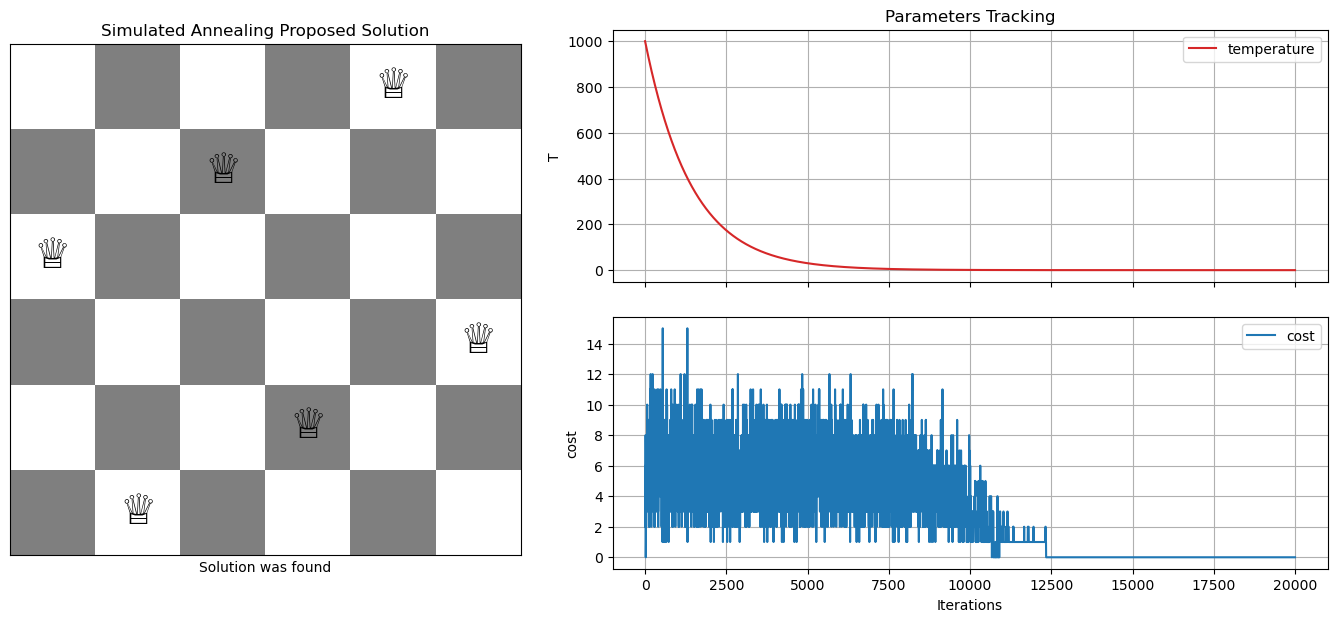

,Property,Value
0,optimal queens configuration,"[4.0, 2.0, 0.0, 5.0, 3.0, 1.0]"
1,cost at optimal configuration,0
2,total search samples,20000 samples
3,accepted samples,9620 samples
4,rejected samples,10380 samples


In [22]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                             ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})


# simulated annealing solution proposal plot
print_board(ax['upper left'], x_optimal)
solution = "Solution was found" if history["cost"].iloc[-1] == 0  else "Solution was not found"
ax['upper left'].set(xlabel= solution, title="Simulated Annealing Proposed Solution")

# temperature value tracking
ax['upper right'].plot(history["temperature"], "tab:red", label="temperature")
ax['upper right'].set(ylabel="T", title="Parameters Tracking")
ax['upper right'].xaxis.set_ticklabels([])
ax['upper right'].grid(True)
ax['upper right'].legend()

# cost value tracking
ax['lower right'].plot(history["cost"], label="cost")
ax['lower right'].set(xlabel="Iterations", ylabel="cost")
ax['lower right'].grid(True)
ax['lower right'].legend()

# summary
summary = [
    ("optimal queens configuration", x_optimal),
    ("cost at optimal configuration", cost_function(x_optimal)),
    ("total search samples", f'{len(history["x"])} samples'),
    ("accepted samples", f'{accepted_samples} samples'),
    ("rejected samples", f'{len(history["x"]) - accepted_samples} samples')
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()
df